<a href="https://colab.research.google.com/github/aisawanj/Data_Pipeline_ETL_on_Airflow/blob/main/Project_02_Data_Pipeline_(ETL)_on_Airflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project_02: Data Pipeline (ETL) on Airflow**

Perform ETL operations on data using Airflow with the Airflow Operator and export the data to a data warehouse on Google BigQuery using the GCSToBigQueryOperator.

*Remarks : The Source Code has been referenced URL from DataTH for testing "project_02" / Cr.DataTH.*

### 1. Graph of DAG “gcs_to_bq_dag” on Airflow

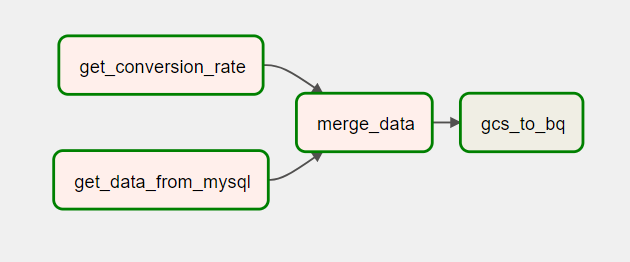

### 2. Gantt of DAG “gcs_to_bq_dag” on Airflow

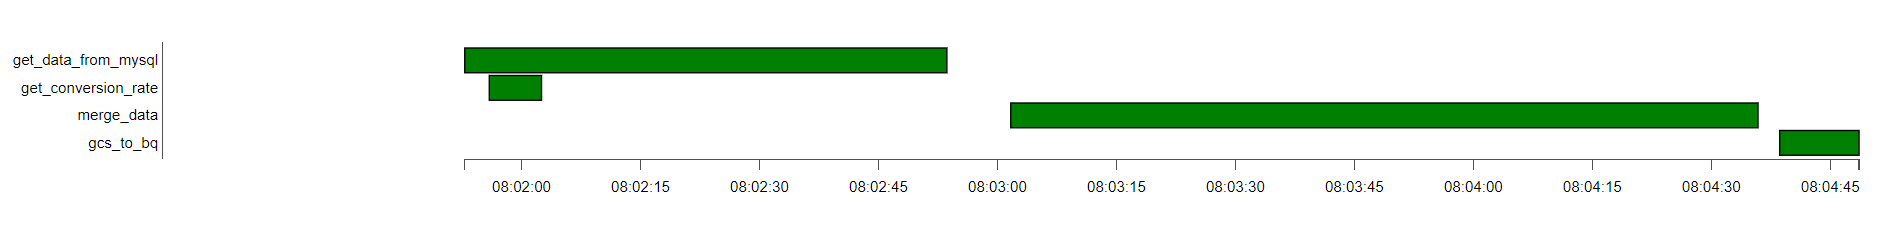

### 3. Code of DAG “gcs_to_bq_dag” on Airflow

In [ ]:
# Importing Modules
from airflow.models import DAG
from airflow.operators.bash import BashOperator
from airflow.operators.python import PythonOperator
from airflow.providers.google.cloud.transfers.gcs_to_bigquery import GCSToBigQueryOperator
from airflow.providers.mysql.hooks.mysql import MySqlHook
from airflow.utils.dates import days_ago
import pandas as pd
import requests

# Connection name on Airflow
MYSQL_CONNECTION = "mysql_default"
CONVERSION_RATE_URL = "https://r2de2-workshop-vmftiryt6q-ts.a.run.app/usd_thb_conversion_rate"

# Default output path
mysql_output_path = "/home/airflow/gcs/data/transaction.csv"
conversion_rate_output_path = "/home/airflow/gcs/data/conversion_rate.csv"
final_output_path = "/home/airflow/gcs/data/output.csv"

def get_data_from_mysql(transaction_path):
    # Browse MySqlHook for connecting MySQL frome Airflow connection
    mysqlserver = MySqlHook(MYSQL_CONNECTION)

    # Query data from database using Hook
    audible_data = mysqlserver.get_pandas_df(sql="SELECT * FROM audible_data")
    audible_transaction = mysqlserver.get_pandas_df(sql="SELECT * FROM audible_transaction")

    # Merge data from 2 DataFrame
    df = audible_transaction.merge(audible_data, how="left", left_on="book_id", right_on="Book_ID")

    # Save CSV file to transaction_path ("/home/airflow/gcs/data/audible_data_merged.csv")
    df.to_csv(transaction_path, index=False)
    print(f"Output to {transaction_path}")

def get_conversion_rate(conversion_rate_path):
    # Get data from REST API with requests package
    r = requests.get(CONVERSION_RATE_URL)
    result_conversion_rate = r.json()

    # Create new datafrme
    df = pd.DataFrame(result_conversion_rate)

    # Change the index to the column "date" and save to CSV file "conversion_rate.csv"
    df = df.reset_index().rename(columns={"index": "date"})
    df.to_csv(conversion_rate_path, index=False)
    print(f"Output to {conversion_rate_path}")

def merge_data(transaction_path, conversion_rate_path, output_path):
    # Read file from parameter "transaction_path" and "conversion_rate_path"
    transaction = pd.read_csv(transaction_path)
    conversion_rate = pd.read_csv(conversion_rate_path)

    # Convert data type to be date type in both dataframes (transaction, conversion_rate)
    transaction['date'] = transaction['timestamp']
    transaction['date'] = pd.to_datetime(transaction['date']).dt.date
    conversion_rate['date'] = pd.to_datetime(conversion_rate['date']).dt.date

    # Create new dataframe "final_df" by merge 2 dataframe (transaction & conversion_rate)
    final_df = transaction.merge(conversion_rate, how="left", left_on="date", right_on="date")

    # Edit column "Price" by replacing "$" to "" and converting data type is float
    final_df["Price"] = final_df.apply(lambda x: x["Price"].replace("$",""), axis=1)
    final_df["Price"] = final_df["Price"].astype(float)

    # Create a new column "THB_Price" with column "Price" multiply "conversion_rate
    final_df["THBPrice"] = final_df["Price"] * final_df["conversion_rate"]
    final_df = final_df.drop(["date", "book_id"], axis=1)

    # Save to CSV file
    final_df.to_csv(output_path, index=False)
    print(f"Output to {output_path}")

# Create DAG "gcs_to_bq_dag" on Airflow
with DAG(
    "gcs_to_bq_dag",
    start_date=days_ago(1),
    schedule_interval="@once",
    tags=["Project_02"]
) as dag:

    # Create task in DAG "gcs_to_bq_dag"
    t1 = PythonOperator(
        task_id="get_data_from_mysql",
        python_callable=get_data_from_mysql,
        op_kwargs={"transaction_path": mysql_output_path},
    )
    t2 = PythonOperator(
        task_id="get_conversion_rate",
        python_callable=get_conversion_rate,
        op_kwargs={"conversion_rate_path": conversion_rate_output_path},
    )
    t3 = PythonOperator(
        task_id="merge_data",
        python_callable=merge_data,
        op_kwargs={
            "transaction_path": mysql_output_path,
            "conversion_rate_path": conversion_rate_output_path,
            "output_path": final_output_path
        },
    )
    # Create task 4 (GCSToBigQueryOperator) for export file to BigQuery
    t4 = GCSToBigQueryOperator(
        task_id='gcs_to_bq',
        bucket='us-central1-testcomposer-39737e8c-bucket',
        source_objects=['data/output.csv'],
        destination_project_dataset_table='data_integration.transaction_data',
        skip_leading_rows=1,
        schema_fields=[
            {
                "mode": "NULLABLE",
                "name": "timestamp",
                "type": "TIMESTAMP"
            },
            {
                "mode": "NULLABLE",
                "name": "user_id",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "country",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Book_ID",
                "type": "INTEGER"
            },
            {
                "mode": "NULLABLE",
                "name": "Book_Title",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Book_Subtitle",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Book_Author",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Book_Narrator",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Audio_Runtime",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Audiobook_Type",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Categories",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Rating",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Total_No__of_Ratings",
                "type": "FLOAT"
            },
            {
                "mode": "NULLABLE",
                "name": "Price",
                "type": "FLOAT"
            },
            {
                "mode": "NULLABLE",
                "name": "conversion_rate",
                "type": "FLOAT"
            },
            {
                "mode": "NULLABLE",
                "name": "THBPrice",
                "type": "FLOAT"
            }
        ],
        write_disposition='WRITE_TRUNCATE',
    )

# Set up dependencies
    [t1, t2] >> t3 >> t4

# Remarks:
dag.doc_md = 'The Source Code has been referenced URL from DataTH for testing "project_02" / Cr.DataTH.'